# Policy analysis

In [96]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [97]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from matplotlib.ticker import MaxNLocator, MultipleLocator
import json
import ptitprince as pt
import pickle as pkl
# import contextily as ctx
from src.data.analyse import *
import ptitprince as pt
from ema_workbench import load_results
sns.set_theme(style="ticks")

## Load results

In [98]:
# Load results
income_loss = False
results = load_results(f'../results/scenarios=1000, policies=20, income_loss={income_loss}.tar.gz')

# Prepare outcomes data frame
outcomes = prepare_outcomes(results, add_uncertainties=False, add_policies=True)

# This outcome should be studied separately
outcomes.drop('years_in_poverty', axis=1, inplace=True)

# Split my policy into two columns
outcomes[['target_group', 'top_up']] = outcomes['my_policy'].str.split('+', expand=True)

# Make top_up a categorical variable to ensure it is ordered correctly
outcomes['top_up'] = pd.Categorical(outcomes['top_up'], categories=['0', 
                                                                    '10', 
                                                                    '30', 
                                                                    '50', 
                                                                    '100'])

## What is the impact of top-ups across target groups and districts?

In [99]:
df = outcomes.copy()
columns_of_interest = [
       'target_group',
       'top_up', 
       'n_new_poor',
       'annual_average_consumption_loss_pct']
tab = df[columns_of_interest].round(2).groupby(['target_group', 'top_up']).mean(numeric_only=True).round(2)

In [100]:
top_up_mapper = {'0' : 'None', '10' : '10\%', '30': '30\%', '50': '50\%', '100': '100\%'}
target_group_mapper = {'all' : 'All', 'poor' : 'Poor', 'poor_near_poor1.25' : 'Poor and Near Poor (1.25)', 'poor_near_poor2.0' : 'Poor and Near Poor (2.0)'}
outcome_name_mapper = {'annual_average_consumption_loss_pct' : 'Annual average consumption loss (\%)', 'n_new_poor' : 'Number of new poor'}

tab.rename(index = top_up_mapper, inplace = True)
tab.rename(index = target_group_mapper, inplace = True)
tab.rename(columns = outcome_name_mapper, inplace = True)
tab.index.names = ['Target group', 'Top-up percentage']

tab['Number of new poor'] = tab['Number of new poor'].astype(int)

In [101]:
n_target_groups = 4
# n_target_groups = 1
k = 0
m_top_ups = 4
# m_top_ups = 2
for i in range(n_target_groups):
    x = tab.iloc[k, 0]
    y = tab.iloc[k, 1]
    tab.iloc[k, 0] = 0
    tab.iloc[k, 1] = 0
    for j in range(k + 1, k + m_top_ups + 1):
        tab.iloc[j, 0] = x - tab.iloc[j, 0]
        tab.iloc[j, 1] = y - tab.iloc[j, 1]
    k += m_top_ups + 1

tab.columns = ['Average number of people preventing from falling into poverty',
               'Average reduction in consumption loss (\%)']
tab = tab + 0
tab

Average number of people preventing from falling into poverty  \
Target group              Top-up percentage                                                                  
All                       None                                                               0               
                          10\%                                                               5               
                          30\%                                                              22               
                          50\%                                                              40               
                          100\%                                                             67               
Poor                      None                                                               0               
                          10\%                                                               0               
                          30\%                                                               0               
                          50\%                                                               0               
                          100\%                                                              0               
Poor and Near Poor (1.25) None                                                               0               
                          10\%                                                               3               
                          30\%                                                              16               
                          50\%                                                              32               
                          100\%                                                             57               
Poor and Near Poor (2.0)  None                                                               0               
                          10\%                                                               5               
                          30\%                                                              21               
                          50\%                                                              40               
                          100\%                                                             67               

                                             Average reduction in consumption loss (\%)  
Target group              Top-up percentage                                              
All                       None                                                     0.00  
                          10\%                                                     1.11  
                          30\%                                                     3.41  
                          50\%                                                     5.79  
                          100\%                                                   11.84  
Poor                      None                                                     0.00  
                          10\%                                                     0.10  
                          30\%                                                     0.30  
                          50\%                                                     0.51  
                          100\%                                                    1.03  
Poor and Near Poor (1.25) None                                                     0.00  
                          10\%                                                     0.18  
                          30\%                                                     0.55  
                          50\%                                                     0.92  
                          100\%                                                    1.86  
Poor and Near Poor (2.0)  None                                                     0.00  
    

In [102]:
# Make the tex table fit to the page
style = tab.style.format(decimal='.', thousands=',', precision=2)
style.to_latex(buf='../tables/policy_analysis_country.tex',
             caption='Impact of cash transfers across different target groups on the country scale.',
             position='H',
             hrules=True,
             label='tab:policy_analysis_country',
             sparse_index=True,
             sparse_columns=True,
             column_format='p{4cm}p{4cm}p{3cm}p{3cm}p{3cm}'
             )

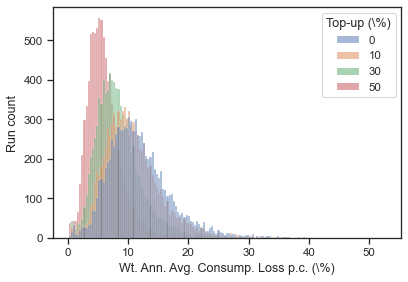

In [103]:
fig, ax = plt.subplots(figsize=(6, 4))

target_group = 'all'
top_ups = ['0', '10', '30', '50'] # , '100']
df = outcomes[outcomes['target_group'] == target_group].copy()
df = df[df['top_up'].isin(top_ups)]
df['top_up'] = df['top_up'].astype(str)
df['top_up'] = pd.Categorical(df['top_up'], categories=top_ups, ordered=True)
df.rename(columns={'top_up': 'Top-up (\%)'}, inplace=True)
outcome_of_interest = 'annual_average_consumption_loss_pct'
sns.histplot(data=df, x=outcome_of_interest, hue='Top-up (\%)', ax=ax)
plt.xlabel('Wt. Ann. Avg. Consump. Loss p.c. (\%)')
plt.ylabel('Run count')
plt.savefig('../figures/policy_analysis/top_up_all.pgf', bbox_inches='tight')
# plt.title('Top-up all affected households');

In [107]:
tab.columns

Index(['scenario', 'policy', 'district', 'random_seed', 'my_policy',
       'total_population', 'total_asset_loss', 'total_consumption_loss',
       'event_damage', 'total_asset_stock', 'average_productivity',
       'total_asset_in_survey', 'expected_loss_fraction', 'n_affected_people',
       'annual_average_consumption', 'poverty_line_adjusted', 'pml',
       'n_poor_initial', 'n_poor_affected', 'n_new_poor',
       'initial_poverty_gap', 'new_poverty_gap',
       'annual_average_consumption_loss',
       'Wt. Ann. Avg. Consump. Loss p.c. (\%)', 'r', 'recovery_rate',
       'n_new_poor_increase_pct', 'target_group', 'Top-up (\%)'],
      dtype='object')

In [108]:
tab = df.copy()
outcome_of_interest = 'Wt. Ann. Avg. Consump. Loss p.c. (\%)'
tab.rename({'annual_average_consumption_loss_pct':
            'Wt. Ann. Avg. Consump. Loss p.c. (\%)'}, inplace=True, axis=1)
tab = tab.groupby('Top-up (\%)').describe()[[outcome_of_interest]]
tab.drop('count', axis=1, level=1, inplace=True)
tab = tab.rename({'25%': '25\%', '50%': '50\%', '75%': '75\%'}, axis=1, level=1)
tab = tab.T
style = tab.style.format(decimal='.', thousands=',', precision=2)
style.to_latex(buf='../tables/top_up_all_country.tex',
               caption='Impact of cash transfers to "All" target group on the country scale.',
               position='H',
               hrules=True,
               label='tab:top_up_all_country',
               sparse_index=True,
               sparse_columns=True,
               # column_format='p{4cm}p{4cm}p{3cm}p{3cm}p{3cm}'
               )

## How the top-up to `all` mitigates the impact of a flood?

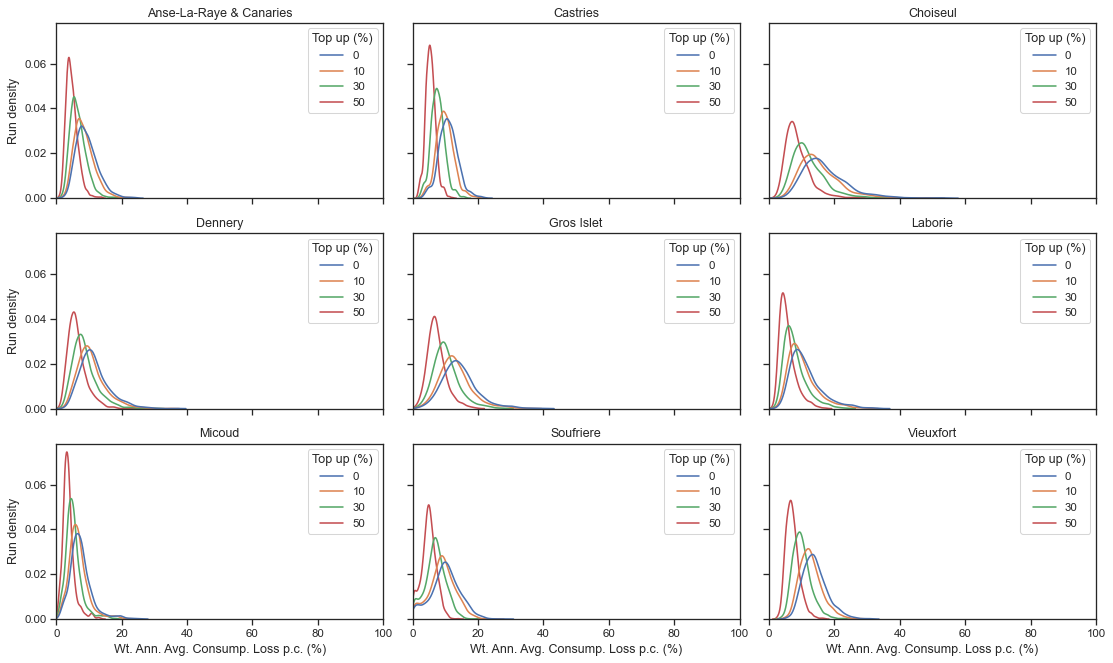

In [112]:
target_group = 'all'
top_ups = ['0', '10', '30', '50']
df = outcomes[outcomes['target_group'] == target_group]
df = df[df['top_up'].isin(top_ups)]
df['top_up'] = pd.Categorical(df['top_up'], categories=top_ups, ordered=True)

districts = df['district'].unique().tolist()
n_districts = len(districts)

fig, ax = plt.subplots(ncols=3, nrows=3, figsize=(5 * n_districts / 3, 3 * n_districts / 3), sharex=True, sharey=True)
colors = sns.color_palette('Set2', n_colors=len(districts))

# outcome_of_interest = 'n_new_poor'

outcome_name_mapper = {'annual_average_consumption_loss_pct': 'Wt. Ann. Avg. Consump. Loss p.c. (%)',
                       'n_new_poor': 'Number of new poor',
                       'n_new_poor_increase_pct' : 'Increase in number of new poor (%)'}

outcome_of_interest = 'annual_average_consumption_loss_pct'

for district in districts:
    data = df[df['district'] == district][['top_up', outcome_of_interest]]
    data.sort_values('top_up', inplace=True)
    data.rename(columns={'top_up': 'Top up (%)'}, inplace=True)
    if district == 'AnseLaRayeCanaries':
        district_name = 'Anse-La-Raye & Canaries'
    else:
        district_name = district
    i = districts.index(district) // 3
    j = districts.index(district) % 3
    color = colors[districts.index(district)]
    # sns.histplot(data=data, 
    #              x=outcome_of_interest, 
    #              hue='Top up', 
    #              ax=ax[i, j], 
    #              # multiple='stack', 
    #              # shrink=.8,
    #              # palette="ch:rot=-.25,hue=1,light=.75"
    #              )
    sns.kdeplot(data=data, 
                 x=outcome_of_interest, 
                 hue='Top up (%)', 
                 ax=ax[i, j], 
                 )
    ax[i, j].set_title(district_name)
    ax[i, j].set_ylabel('Run density')
    ax[i, j].set_xlabel(outcome_name_mapper[outcome_of_interest])
    ax[i, j].set_xlim(0, 100)
# fig.suptitle('Target group: ' + target_group_mapper[target_group], fontsize=16)
fig.tight_layout()
plt.savefig('../figures/policy_analysis/top_up_all_country.png', dpi=300, bbox_inches='tight')

In [12]:
# Select target group
df = outcomes[outcomes['target_group'] == 'all']

# Select districts with low, mid and high consumption annual_average_consumption_loss_pct
districts_of_interest = ['Micoud', 'Laborie', 'Choiseul']
df = df[df['district'].isin(districts_of_interest)]

# Select top-ups of 0, 50 and 100
df = df[df['top_up'].isin(['0', '10', '30', '50'])]
df['top_up'] = df['top_up'].astype('str')
df['top_up'] = pd.Categorical(df['top_up'], ['0', '10', '30', '50'])
df.rename(columns={'top_up': 'Top-up (%)', 'district' : 'District', 'annual_average_consumption_loss_pct': 'Annual average consumption loss (%)'}, inplace=True)
df.sort_values(by='District', inplace=True)

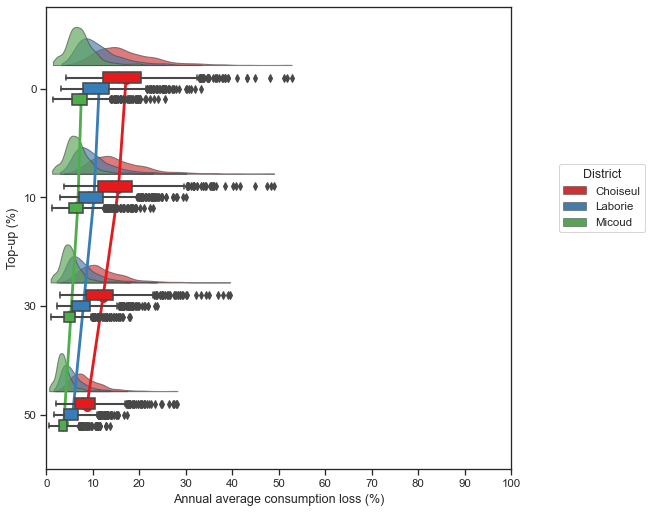

In [13]:
fig, ax = plt.subplots(figsize=(8, 8))

ax = pt.RainCloud(x='Top-up (%)',
                  y='Annual average consumption loss (%)',
                  hue='District',
                  orient='h',
                  data=df,
                  palette='Set1',
                  bw=0.2,
                  width_viol=0.7,
                  width_box=0.3,
                  ax=ax,
                  cut=0,
                  alpha=0.65,
                  dodge=True,
                  pointplot=True,
                  stripplot=False,
                  move=0.2)
ax.set_xlim(0, 100)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:len(districts_of_interest)], labels[:len(
    districts_of_interest)], title='District', loc='lower right', bbox_to_anchor=(1.3, 0.5));
ax.xaxis.set_major_locator(MultipleLocator(10))

## Which policies are the most effective?

### Consumption loss

In [113]:
df = get_policy_effectiveness_tab(outcomes)

In [114]:
# How effective is the policy in reducing income loss?
df.groupby(['Policy']).mean(numeric_only=True)['Annual average consumption loss (%)'].sort_values(ascending=True).round(2)

Policy
100% to all                           0.00
50% to all                            6.05
100% to poor and near poor (2.0)      7.21
30% to all                            8.43
50% to poor and near poor (2.0)       9.60
100% to poor and near poor (1.25)     9.98
30% to poor and near poor (2.0)      10.53
10% to all                           10.73
100% to poor                         10.81
50% to poor and near poor (1.25)     10.92
30% to poor and near poor (1.25)     11.29
50% to poor                          11.33
10% to poor and near poor (2.0)      11.41
30% to poor                          11.54
10% to poor and near poor (1.25)     11.66
10% to poor                          11.74
None                                 11.84
Name: Annual average consumption loss (%), dtype: float64

In [115]:
# What about the effectiveness by district?
df = df.groupby(['District', 'Policy']).mean(numeric_only=True)[['Annual average consumption loss (%)']] 
df = df.sort_values(by=['District', 'Annual average consumption loss (%)'])

In [116]:
top_3_policies = {}
for district in outcomes['district'].unique():
    top_3_policies[district] = df.loc[district, :].iloc[:3].index.tolist()
top_3_policies = pd.DataFrame(top_3_policies).T
top_3_policies.columns = [1, 2, 3]

bottom_3_policies = {}
for district in outcomes['district'].unique():
    bottom_3_policies[district] = df.loc[district, :].iloc[-4:-1].index.tolist()
bottom_3_policies = pd.DataFrame(bottom_3_policies).T
bottom_3_policies.columns = [1, 2, 3]

In [117]:
top_3_policies

,1,2,3
Anse-La-Raye & Canaries,100% to all,50% to all,100% to poor and near poor (2.0)
Castries,100% to all,50% to all,100% to poor and near poor (2.0)
Choiseul,100% to all,50% to all,100% to poor and near poor (2.0)
Dennery,100% to all,100% to poor and near poor (2.0),50% to all
Gros Islet,100% to all,50% to all,30% to all
Laborie,100% to all,50% to all,100% to poor and near poor (2.0)
Micoud,100% to all,50% to all,100% to poor and near poor (2.0)
Soufriere,100% to all,50% to all,100% to poor and near poor (2.0)
Vieuxfort,100% to all,50% to all,100% to poor and near poor (2.0)


In [118]:
bottom_3_policies

,1,2,3
Anse-La-Raye & Canaries,10% to poor and near poor (2.0),10% to poor and near poor (1.25),10% to poor
Castries,30% to poor,10% to poor and near poor (1.25),10% to poor
Choiseul,30% to poor,10% to poor and near poor (1.25),10% to poor
Dennery,30% to poor,10% to poor and near poor (1.25),10% to poor
Gros Islet,30% to poor,10% to poor and near poor (1.25),10% to poor
Laborie,30% to poor,10% to poor and near poor (1.25),10% to poor
Micoud,30% to poor,10% to poor and near poor (1.25),10% to poor
Soufriere,10% to poor and near poor (1.25),30% to poor,10% to poor
Vieuxfort,30% to poor,10% to poor and near poor (1.25),10% to poor


### Number of poor

In [20]:
df = get_policy_effectiveness_tab(outcomes)

In [21]:
# How effective is the policy in reducing income loss?
df.groupby(['Policy']).mean(numeric_only=True)['Number of new poor'].sort_values(ascending=True).round(2)

Policy
100% to all                           0.00
100% to poor and near poor (2.0)      0.40
100% to poor and near poor (1.25)    10.54
50% to all                           27.19
50% to poor and near poor (2.0)      27.57
50% to poor and near poor (1.25)     35.42
30% to all                           45.71
30% to poor and near poor (2.0)      46.08
30% to poor and near poor (1.25)     51.02
10% to all                           62.26
10% to poor and near poor (2.0)      62.56
10% to poor and near poor (1.25)     64.05
None                                 67.02
30% to poor                          67.02
10% to poor                          67.02
50% to poor                          67.02
100% to poor                         67.02
Name: Number of new poor, dtype: float64

In [22]:
# How effective is the policy in reducing number of new poor
df = df.groupby(['District', 'Policy']).mean(numeric_only=True)[['Number of new poor']] 
df = df.sort_values(by=['District', 'Number of new poor'])

In [23]:
df

Number of new poor
District                Policy                                               
Anse-La-Raye & Canaries 100% to all                                     0.000
                        100% to poor and near poor (2.0)                0.000
                        50% to all                                      1.653
                        50% to poor and near poor (2.0)                 1.653
                        100% to poor and near poor (1.25)               6.711
...                                                                       ...
Vieuxfort               None                                          132.305
                        10% to poor                                   132.305
                        30% to poor                                   132.305
                        50% to poor                                   132.305
                        100% to poor                                  132.305

[153 rows x 1 columns]

In [24]:
top_3_policies = {}
for district in outcomes['district'].unique():
    top_3_policies[district] = df.loc[district, :].iloc[:3].index.tolist()
top_3_policies = pd.DataFrame(top_3_policies).T
top_3_policies.columns = [1, 2, 3]

bottom_3_policies = {}
for district in outcomes['district'].unique():
    bottom_3_policies[district] = df.loc[district, :].iloc[-4:-1].index.tolist()
bottom_3_policies = pd.DataFrame(bottom_3_policies).T
bottom_3_policies.columns = [1, 2, 3]

In [25]:
top_3_policies

,1,2,3
Anse-La-Raye & Canaries,100% to all,100% to poor and near poor (2.0),50% to all
Castries,100% to all,100% to poor and near poor (2.0),100% to poor and near poor (1.25)
Choiseul,100% to all,100% to poor and near poor (2.0),100% to poor and near poor (1.25)
Dennery,100% to all,100% to poor and near poor (2.0),50% to all
Gros Islet,100% to all,100% to poor and near poor (2.0),50% to all
Laborie,100% to all,100% to poor and near poor (2.0),100% to poor and near poor (1.25)
Micoud,100% to all,100% to poor and near poor (2.0),50% to all
Soufriere,100% to all,100% to poor and near poor (2.0),100% to poor and near poor (1.25)
Vieuxfort,100% to all,100% to poor and near poor (2.0),100% to poor and near poor (1.25)


In [26]:
bottom_3_policies

,1,2,3
Anse-La-Raye & Canaries,10% to poor,30% to poor,50% to poor
Castries,10% to poor,30% to poor,50% to poor
Choiseul,10% to poor,30% to poor,50% to poor
Dennery,10% to poor,30% to poor,50% to poor
Gros Islet,10% to poor,30% to poor,50% to poor
Laborie,10% to poor,30% to poor,50% to poor
Micoud,10% to poor,30% to poor,50% to poor
Soufriere,10% to poor,30% to poor,50% to poor
Vieuxfort,10% to poor,30% to poor,50% to poor
